In [ ]:
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from keras.optimizers import Adam
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.utils import to_categorical
from keras.models import Model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras import optimizers  
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [ ]:
#Loading the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Unzip the Training data folder
!unzip /content/drive/MyDrive/Colab/257_termProj/Data.zip -d mydata

Streaming output truncated to the last 5000 lines.
  inflating: mydata/imgs/train/c7/img_56636.jpg  
  inflating: mydata/imgs/train/c7/img_56661.jpg  
  inflating: mydata/imgs/train/c7/img_56699.jpg  
  inflating: mydata/imgs/train/c7/img_56717.jpg  
  inflating: mydata/imgs/train/c7/img_56724.jpg  
  inflating: mydata/imgs/train/c7/img_56768.jpg  
  inflating: mydata/imgs/train/c7/img_56779.jpg  
  inflating: mydata/imgs/train/c7/img_56849.jpg  
  inflating: mydata/imgs/train/c7/img_56899.jpg  
  inflating: mydata/imgs/train/c7/img_56938.jpg  
  inflating: mydata/imgs/train/c7/img_5706.jpg  
  inflating: mydata/imgs/train/c7/img_57076.jpg  
  inflating: mydata/imgs/train/c7/img_57122.jpg  
  inflating: mydata/imgs/train/c7/img_57137.jpg  
  inflating: mydata/imgs/train/c7/img_5715.jpg  
  inflating: mydata/imgs/train/c7/img_57278.jpg  
  inflating: mydata/imgs/train/c7/img_57321.jpg  
  inflating: mydata/imgs/train/c7/img_57345.jpg  
  inflating: mydata/imgs/train/c7/img_57355.jpg  
 

In [ ]:
#Fetching the driver Details
driver_info = pd.read_csv('/content/mydata/driver_imgs_list.csv',na_values='na')
print(driver_info.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [ ]:
#Resizing and processing the image into numpy array and Extracting labels for the array
train_image = []
image_label = []

for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/content/mydata/imgs/train/c"+str(i))
    for j in range(len(imgs)):
    #for j in range(100):
        img_name = "/content/mydata/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_info[driver_info['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [ ]:
#Shuffling the Training data
import random
random.shuffle(train_image)

In [ ]:
#Selecting specific drivers for validation
driver_selected = ['p050', 'p015', 'p022', 'p056']

In [ ]:
#Splitting the data into training and validation data.
training_data= []
training_labels = []
validation_data = []
validation_labels = []
driverTrain = []
driverTest = []
true_Validation_labels = []

for features,labels,drivers in train_image:
    if drivers in driver_selected:
        validation_data.append(features)
        validation_labels.append(labels)
        driverTest.append(drivers)
        true_Validation_labels.append(labels)
    
    else:
        training_data.append(features)
        training_labels.append(labels)
        driverTrain.append(drivers)
    
print (len(training_data),len(validation_data))
print (len(training_labels),len(validation_labels))

18732 3692
18732 3692


In [ ]:
#Resizing the data for the model and categorising the labels.
X_train = np.array(training_data).reshape(-1,224,224,3)
X_test = np.array(validation_data).reshape(-1,224,224,3)
y_train = to_categorical(training_labels)
y_test = to_categorical(validation_labels)
print ('Shape of Training data :',X_train.shape)

Shape of Training data : (18732, 224, 224, 3)


Creating the base Model


In [ ]:
#Creating mobilenet base model and using the imagenet weights.
base_model=MobileNet(weights='imagenet',include_top=False,input_shape=(224,224,3)) 
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

Adding the custom classifier to the base model.

In [ ]:
#Adding output classifier layer.
x=base_model.output
x=GlobalAveragePooling2D()(x)
preds=Dense(10,activation='softmax')(x) #final layer with softmax activation
model = Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

Training the VGG16 custom model

In [ ]:
#Adding optimizer for the model and compiling the model.
sgd = optimizers.SGD(lr = 0.005)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Adding checkpoints and early stopping creteria for the model
checkpointer = ModelCheckpoint('mobilenet_sgd_nolayers.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

#Training the model with hyper parameters
mobilenet_model = model.fit(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/25
293/292 [==============================] - ETA: 0s - loss: 1.8695 - accuracy: 0.3619
Epoch 00001: val_loss improved from inf to 1.07872, saving model to mobilenet_sgd_nolayers.hdf5
293/292 [==============================] - 179s 611ms/step - loss: 1.8695 - accuracy: 0.3619 - val_loss: 1.0787 - val_accuracy: 0.6582
Epoch 2/25
293/292 [==============================] - ETA: 0s - loss: 1.0558 - accuracy: 0.6620
Epoch 00002: val_loss improved from 1.07872 to 0.59732, saving model to mobilenet_sgd_nolayers.hdf5
293/292 [==============================] - 178s 607ms/step - loss: 1.0558 - accuracy: 0.6620 - val_loss: 0.5973 - val_accuracy: 0.8058
Epoch 3/25
293/292 [==============================] - ETA: 0s - loss: 0.8009 - accuracy: 0.7388
Epoch 00003: val_loss improved from 0.59732 to 0.48535, saving model to mobilenet_sgd_nolayers.hdf5
293/292 [==============================] - 178s 607ms/step - loss: 0.8009 - accuracy: 0.7388 - val_loss: 0.4854 - val_accuracy: 0.8361
Epoch 4/25


In [ ]:
def plot_train_history(history):
    # Plotting accuracy over the Epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Plotting loss over the Epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

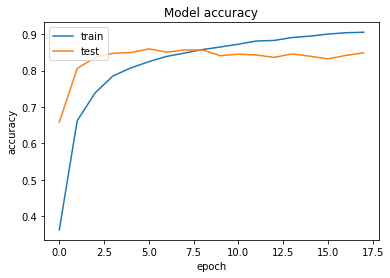

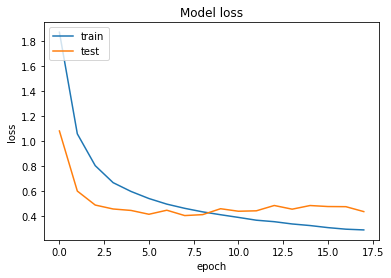

In [ ]:
#Ploting the model accuracy and model loss over epochs.
plot_train_history(mobilenet_model)

Generating labels for the non-labeled test data

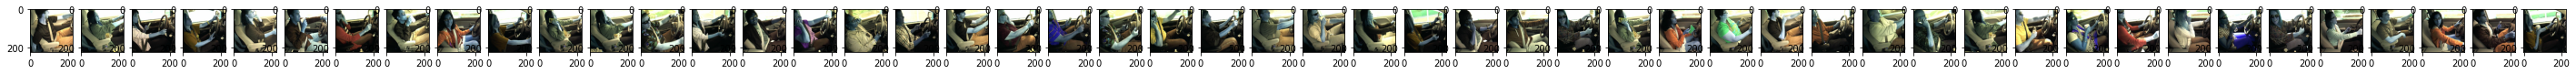

In [ ]:
#Extracting random 50 images from non-labelled test data.
test_image = []
i = 0
fig, ax = plt.subplots(1, 50, figsize = (50,50 ))
img_rows = 224
img_cols = 224
color_type = 3
files = os.listdir('/content/mydata/imgs/test/')
nums = np.random.randint(low=1, high=len(files), size=50)
for i in range(50):
    img = cv2.imread('/content/mydata/imgs/test/'+files[nums[i]])
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    plt.show

In [ ]:
#Predicting classes for the random test data.
test = []
for img in test_image:
    test.append(img)
    
model.load_weights('/content/mobilenet_sgd_nolayers.hdf5')

test = np.array(test).reshape(-1,224,224,3)
prediction = model.predict(test)

In [ ]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

In [ ]:
#Displaying the images with predicted classes.
i = 0
fig, ax = plt.subplots( 50, 1, figsize = (200,200))
for i in range(50):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show

Output hidden; open in https://colab.research.google.com to view.

Getting the classification report for the validation data

In [ ]:
#Predicting the classes for the validation  data.
pred_class = []
val_prediction = model.predict(X_test)

for i in range(len(val_prediction)):
      pred_class.append(np.where(val_prediction[i] == np.amax(val_prediction[i]))[0][0])

In [ ]:
#Printing confusion matrix for the validation data.
print('Images Predicted until now:',len(val_prediction))
print('The accuracy of this model over validation set is:',accuracy_score(true_Validation_labels,pred_class))
confusion_matrix(true_Validation_labels,pred_class)

Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.8334236186348862


array([[333,   1,   0,  16,   6,  15,   0,   0,   0,  41],
       [ 39, 284,   0,   0,   0,   1,  14,   0,   1,   0],
       [  0,   0, 328,   0,   0,   0,   0,   0,  20,   0],
       [  5,   0,   0, 388,   2,   0,   0,   0,   3,   1],
       [  4,   0,   0,   0, 296,  13,   0,   0,  83,   0],
       [  5,   0,   0,   2,   0, 395,   0,   0,   0,   1],
       [ 22,   0,   6,   0,   0,   0, 309,   0,  52,   3],
       [  0,   0,   0,   0,   0,   0,   0, 330,   2,   2],
       [ 19,   0,  30,   0,   2,   0,  20,  91, 166,   4],
       [ 49,   0,   0,  12,   4,  17,   1,   3,   3, 248]])

Testing the labeled test data 

In [ ]:
!unzip /content/drive/MyDrive/Colab/257_termProj/Test_Data.zip -d myTestData

Archive:  /content/drive/MyDrive/Colab/257_termProj/Test_Data.zip
  inflating: myTestData/Test_Data/c9/img_507.jpg  
  inflating: myTestData/Test_Data/c2/img_49.jpg  
  inflating: myTestData/Test_Data/c9/img_102137.jpg  
  inflating: myTestData/Test_Data/c9/img_102078.jpg  
  inflating: myTestData/Test_Data/c8/img_630.jpg  
  inflating: myTestData/Test_Data/c8/img_549.jpg  
  inflating: myTestData/Test_Data/c8/img_43.jpg  
  inflating: myTestData/Test_Data/c9/img_102066.jpg  
  inflating: myTestData/Test_Data/c2/img_33.jpg  
  inflating: myTestData/Test_Data/c9/img_44.jpg  
  inflating: myTestData/Test_Data/c2/img_25.jpg  
  inflating: myTestData/Test_Data/c2/img_86.jpg  
  inflating: myTestData/Test_Data/c9/img_36.jpg  
  inflating: myTestData/Test_Data/c9/img_622.jpg  
  inflating: myTestData/Test_Data/c9/img_102104.jpg  
  inflating: myTestData/Test_Data/c2/img_87.jpg  
  inflating: myTestData/Test_Data/c9/img_102131.jpg  
  inflating: myTestData/Test_Data/c9/img_102045.jpg  
  infl

In [ ]:
#Extracting classes from test data.
final_image = []
image_label = []
for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/content/myTestData/Test_Data/c"+str(i))
    for j in range(len(imgs)):
        img_name = "/content/myTestData/Test_Data/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        final_image.append([img,label])
        image_label.append(i)

now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [ ]:
#Getting Test data and categorical labels.
X_test_new = []
y_test_new = []
for features,labels in final_image:
        X_test_new.append(features)
        y_test_new.append(labels)

X_newtest = np.array(X_test_new).reshape(-1,224,224,3) 
print (len(X_test_new),len(y_test_new))

295 295


In [ ]:
#Predicting class for labelled test data
final_pred = []
model_prediction = model.predict(X_newtest)
for i in range(len(model_prediction)):
      final_pred.append(np.where(model_prediction[i] == np.amax(model_prediction[i]))[0][0])

In [ ]:
#Method to print the confusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [ ]:
#Checking the accuracy of the model.
print('Images Predicted until now:',len(model_prediction))
print('The accuracy of this model over test set is:',accuracy_score(y_test_new,final_pred))
print(confusion_matrix(y_test_new,final_pred))

Images Predicted until now: 295
The accuracy of this model over test set is: 0.8745762711864407
[[28  0  0  0  0  1  1  0  1  7]
 [ 0 32  0  2  0  0  1  0  1  0]
 [ 0  0 33  0  0  0  1  0  3  0]
 [ 1  0  0 25  1  0  0  0  0  0]
 [ 1  0  1  0 32  0  0  0  1  0]
 [ 0  0  0  0  0 32  0  0  0  0]
 [ 0  0  1  0  0  0 29  0  1  0]
 [ 0  0  0  0  0  0  1 33  0  1]
 [ 0  0  0  0  1  0  1  0  4  0]
 [ 2  1  1  1  0  2  0  0  1 10]]


In [ ]:
Class_Name = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind', 
               'hair and makeup', 'talking to passenger']

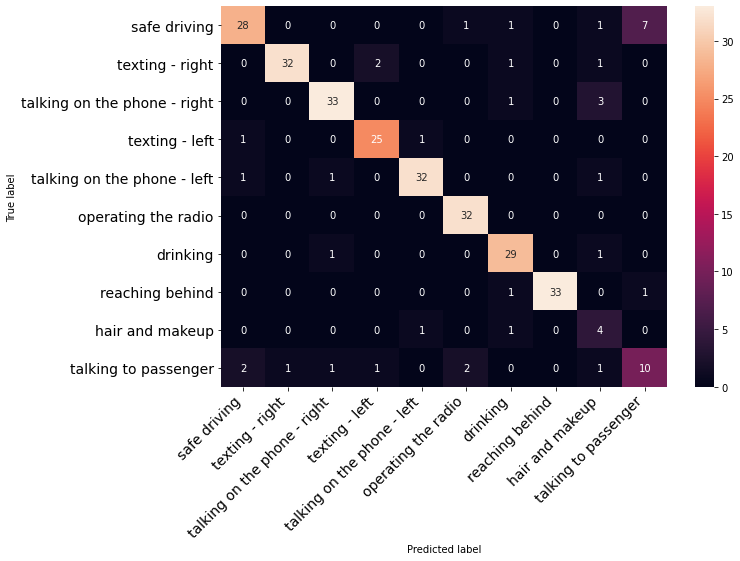

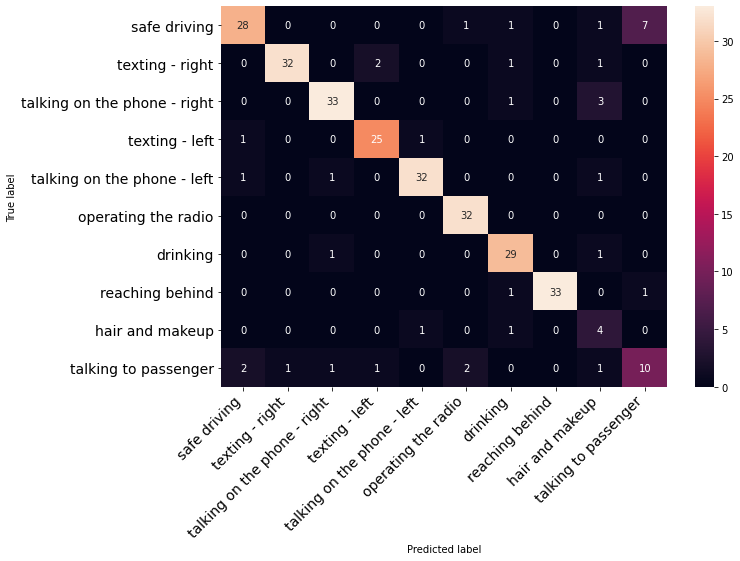

In [ ]:
#Printing the confusion Matrix
cm = confusion_matrix(y_test_new,final_pred)
print_confusion_matrix(cm,Class_Name)